In [1]:
import numpy as np
import itertools
# %matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from matplotlib import animation
from matplotlib.patches import Polygon
import cv2

# Let's first define hyperparameters. In our case, we set the image height H and width H to 128 pixels.
H, W = 128, 128

In [2]:
###########################
##### Helper Function #####
###########################
def get_cube(center=(0, 0, 2), rotation_angles=[0., 0., 0.], scale=1.):
    ''' Returns an array containing the faces of a cube.

    Args:
    center (tuple): center of the cube
    rotation_angles (tuple): Euler angles describing the rotation of the cube
    scale (float): scale of cube

    '''
    # A cube consists of 6 faces and 8 corners:
    #   +----+
    #  /    /|
    # +----+ |
    # |    | +
    # |    |/
    # +----+
    # Let's first consider the unit cube. The corners are:
    corners = np.array([(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)])
    # Let's now center the cube at (0, 0, 0)
    corners = corners - np.array([0.5, 0.5, 0.5], dtype=np.float32).reshape(1, 3)
    # Let's scale the cube
    corners = corners * scale
    # And we rotate the cube wrt. the input rotation angles
    rot_mat = R.from_euler('xyz', rotation_angles, degrees=True).as_matrix()
    corners = np.matmul(corners, rot_mat.T)
    # Finally, we shift the cube according to the input center tuple
    corners = corners + np.array(center, dtype=np.float32).reshape(1, 3)

    # The 6 faces of the cube are then given as:
    faces = np.array([
    # all faces containing (0, 0, 0)
    [corners[0], corners[1], corners[3], corners[2]],
    [corners[0], corners[1], corners[5], corners[4]],
    [corners[0], corners[2], corners[6], corners[4]],
    # all faces containing (1, 1, 1)
    [corners[-1], corners[-2], corners[-4], corners[-3]],
    [corners[-1], corners[-2], corners[-6], corners[-5]],
    [corners[-1], corners[-3], corners[-7], corners[-5]],
    ])


    return faces

In [3]:
def get_camera_intrinsics(alpha=70, beta=70, cx=W/2., cy=H/2.):
    """ Returns the camera intrinsics matrix.

    Hint: The array should be of size 3x3 and of dtype float32 (see the assertion below)

    Args:
    alpha (float): focal length in x-direction f_x
    beta (float): focal length in y-direction f_y
    cx (float): x component of the principal point
    cy (float): y component of th principal point
    """
    # the principal point is at the center
    K = np.array([[alpha, 0, cx],
                  [0, beta, cy],
                  [0, 0, 1]], dtype=np.float32)
    
    return K

In [4]:
def get_perspective_projection(x_c, K):
    """ Projects the 3D point x_c to screen space and returns the 2D pixel coordinates.

    Args:
        x_c (array): 3D points in camera space (nx3), n is the num of points
        K (array): camera intrinsics matrix (3x3)
    """
    # apply the intrinsic matrix to the 3D points
    x_c_homogeneous = np.hstack((x_c, np.ones((x_c.shape[0], 1))))  # convert to homogeneous coordinates (nx4)
    x_s_homogeneous = np.dot(K, x_c_homogeneous.T[:3]).T  # project points (nx3)

    # normalize to get pixel coordinates
    x_s = x_s_homogeneous[:, :2] / x_s_homogeneous[:, 2:]

    return x_s.astype(int)  # convert to integer pixel coordinates

In [5]:
def project_cube(cube, K):
    """ Projects the cube.
    
    Args:
        cube (array): cube
        K (array): camera intrinsics matrix
    """
    projected_cube = []
    
    for face in cube:
        # ensure each face is a 4x3 array
        # face = face.reshape(4, 3)
        projected_face = get_perspective_projection(face, K)
        projected_cube.append(projected_face)
        
    return np.array(projected_cube)

In [6]:
def plot_projected_cube(projected_cube):
    """ Plots the projected cube.

    Args:
    projected_cube (array): projected cube (size 6x4x2)
    """
    plt.figure(figsize=(8, 6))
    for face in projected_cube:
        face = face.astype(int)
        polygon = plt.Polygon(face, closed=True, fill=True, 
                              edgecolor='b', facecolor='b', linewidth=2, alpha=0.5)
        plt.gca().add_patch(polygon)
    plt.xlim(0, W)
    plt.ylim(0, H)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Projected Cube')
    plt.show()

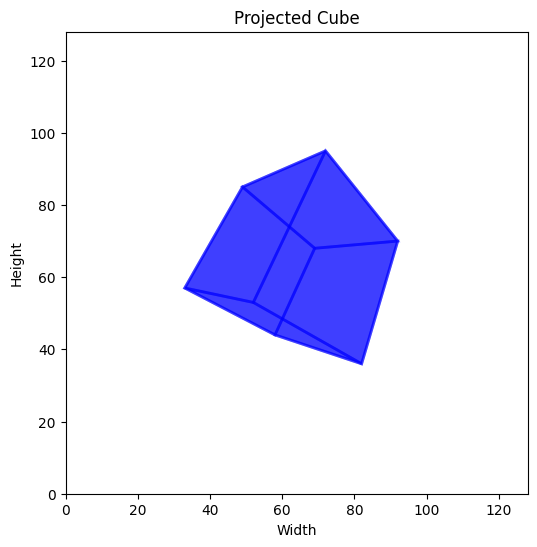

In [7]:
K = get_camera_intrinsics()
cube = get_cube(rotation_angles=[30, 50, 0])
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube)

#### Cube Orientation Example: $rotation\_angles=[50, 30, 20]$

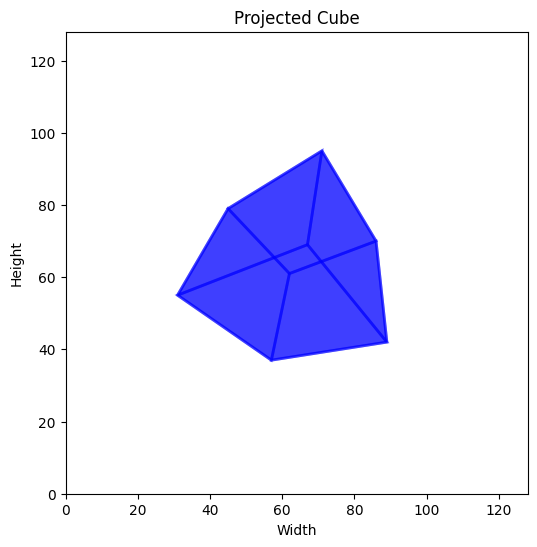

In [8]:
K = get_camera_intrinsics()
cube = get_cube(rotation_angles=[50, 30, 20])
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube)

#### Cube Position Example: $center=(1, 1, 3)$

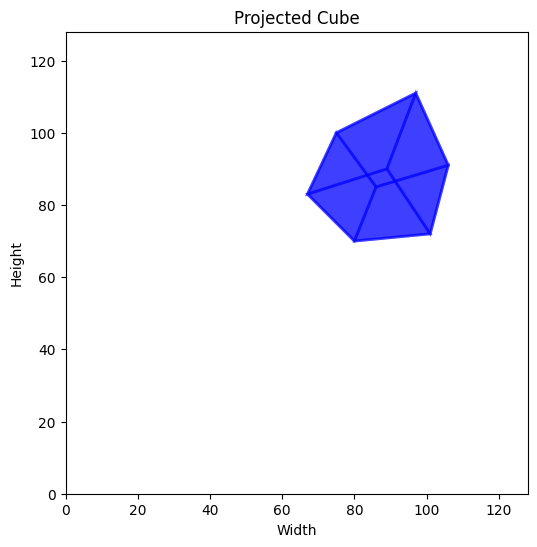

In [9]:
K = get_camera_intrinsics()
cube = get_cube(rotation_angles=[30, 50, 0], center=(1, 1, 3))
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube)

#### Focal Length Example: $alpha=100$, $beta=100$

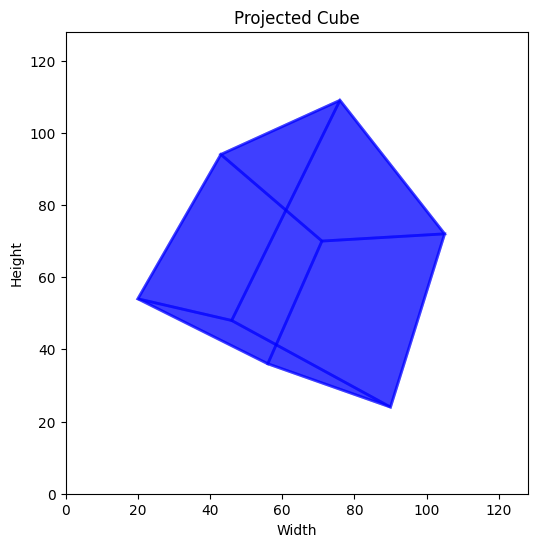

In [10]:
K = get_camera_intrinsics(alpha=100, beta=100)
cube = get_cube(rotation_angles=[30, 50, 0])
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube)